# bnrs_analysis: preprocessing

In [1]:
import os
import re
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

## (0) Load

### > (a) experimental data
- qualtrics data (QSNRSDx, df, .csv), n=5 files, responses from qualtrics. 
- news data (hxryrz_news, df, .pkl), n=5 files, news article content. 
- recs data (hxryrz_recs, dict, .pkl), n=5 files, recommendation IDs. 

In [2]:
#specify study parameters (here these are only used to construct filepaths for loading data): 
study_dates = ['2024-08-14', '2024-08-15', '2024-08-16', '2024-08-21', '22-08-2024'] 
display_window = 4 #number of retrospective days of news content that was included in the experimental pipeline (4)
SIM_CUTOFF = 0.9 #similarity cutoff that was used for the event clutering algorithm (0.9)
database = 'nl' #database code that was used to fetch news articles from local server (nl)
datadir = os.path.join(os.getcwd(), 'data')

In [3]:
def load_datasets_for_study_dates(study_dates, display_window, datadir, database, SIM_CUTOFF):

    #master objects: 
    qualtrics_data_list = [] #combined qualtrics .csv exports (->df)
    news_data_list = [] #combined corpus data (->df)
    HxRyRz_recs_dict = {} #combined recommendation data (->dict)

    #sub-function to load qualtrics data:
    def load_qualtrics(filepath):
        data_df = pd.read_csv(filepath)
        data_df = data_df.drop([0, 1]) #drop and clean
        data_df.columns = data_df.columns.str.replace('\xa0', '') 
        data_df.columns = data_df.columns.str.replace(' ', '')
        #set index to 'ResponseId' column:
        data_df = data_df.set_index('ResponseId')
        #drop any rows associated with non-consent:
        positive_consent = 'Ik geef toestemming voor deelname aan dit onderzoek.'
        non_consent_count = len(data_df[data_df['PIS/ICF'] != positive_consent])
        data_df = data_df[data_df['PIS/ICF'] == positive_consent]
        print(f'Dropped {non_consent_count} non-consenters, leaving {len(data_df)} valid participants.')

        return data_df

    #for each study day, load in the datasets:
    for idx, study_date in enumerate(study_dates, start=1):

        #determine the start and stop dates: 
        study_date = pd.to_datetime(study_date)
        stop_date = study_date - pd.DateOffset(days=1)
        start_date = stop_date - pd.DateOffset(days=display_window-1)
        start_date_str = start_date.strftime('%Y-%m-%d')
        stop_date_str = stop_date.strftime('%Y-%m-%d')
        
        #compose the relevant filepaths (qualtrics, news, recs):
        qual_filepath = f'{datadir}/D{idx}/QSNRSD{idx}.csv'
        news_filepath = f'{datadir}/D{idx}/HxRyRz_news_{database}_{start_date_str}_{stop_date_str}_{SIM_CUTOFF}C.pkl'
        recs_filepath = f'{datadir}/D{idx}/HxRyRz_recs_{database}_{start_date_str}_{stop_date_str}_{SIM_CUTOFF}C.pkl'
        
        #i) load QUALTRICS data: 
        data_df = load_qualtrics(qual_filepath) 
        additional_data = pd.DataFrame({
            'study_day': [int(idx)] * len(data_df),
            'study_date': [study_date] * len(data_df)
        }, index=data_df.index)
        data_df = pd.concat([data_df, additional_data], axis=1)
        qualtrics_data_list.append(data_df) 
        
        #ii) load NEWS data:
        HxRyRz_news = pd.read_pickle(news_filepath) 
        news_data_list.append(HxRyRz_news)
        
        #iii) load RECOMMENDATION data:
        HxRyRz_recs = pd.read_pickle(recs_filepath) 
        HxRyRz_recs_dict[idx] = HxRyRz_recs 
        
        #report load status for this day:    
        print(f"Loaded data for study date {study_date.strftime('%Y-%m-%d')} (Day {idx}) covering {start_date_str} to {stop_date_str}:")
        print(f" HxRyRz_news file: {news_filepath}")
        print(f" HxRyRz_recs file: {recs_filepath}")
        print(f" Data file: {qual_filepath}")
        print()

    #combine all qualtrics data into a single dataframe
    combined_qualtrics_data = pd.concat(qualtrics_data_list)
    
    #combine all news data into a single dataframe
    combined_news_data = pd.concat(news_data_list)
    
    return {
        'qualtrics_data': combined_qualtrics_data,
        'news_data': combined_news_data,
        'HxRyRz_recs': HxRyRz_recs_dict
    }
loaded_datasets = load_datasets_for_study_dates(study_dates, display_window, datadir, database, SIM_CUTOFF)

data_df = loaded_datasets['qualtrics_data']  # all qualtrics data, incl. study day.
HxRyRz_news = loaded_datasets['news_data']  # all news (content) data, incl. embeddings. 
HxRyRz_recs = loaded_datasets['HxRyRz_recs']  # all recommendations data, incl. strategies. 

Dropped 19 non-consenters, leaving 176 valid participants.
Loaded data for study date 2024-08-14 (Day 1) covering 2024-08-10 to 2024-08-13:
 HxRyRz_news file: /Users/rupertkiddle/Desktop/repo/1_NEWSFLOWS/bnrs_replication/bnrs_analysis/data/D1/HxRyRz_news_nl_2024-08-10_2024-08-13_0.9C.pkl
 HxRyRz_recs file: /Users/rupertkiddle/Desktop/repo/1_NEWSFLOWS/bnrs_replication/bnrs_analysis/data/D1/HxRyRz_recs_nl_2024-08-10_2024-08-13_0.9C.pkl
 Data file: /Users/rupertkiddle/Desktop/repo/1_NEWSFLOWS/bnrs_replication/bnrs_analysis/data/D1/QSNRSD1.csv

Dropped 12 non-consenters, leaving 203 valid participants.
Loaded data for study date 2024-08-15 (Day 2) covering 2024-08-11 to 2024-08-14:
 HxRyRz_news file: /Users/rupertkiddle/Desktop/repo/1_NEWSFLOWS/bnrs_replication/bnrs_analysis/data/D2/HxRyRz_news_nl_2024-08-11_2024-08-14_0.9C.pkl
 HxRyRz_recs file: /Users/rupertkiddle/Desktop/repo/1_NEWSFLOWS/bnrs_replication/bnrs_analysis/data/D2/HxRyRz_recs_nl_2024-08-11_2024-08-14_0.9C.pkl
 Data file: /Us

/var/folders/r1/j18tpp5j7jbdhprr5v5r918h0000gn/T/ipykernel_61953/2782918715.py:28: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  study_date = pd.to_datetime(study_date)


### > (b) demographic data

In [4]:
demos = pd.read_spss(datadir+'/db01.sav') 

#AGE - 
#convert lft column to integer:
demos['lft'] = demos['lft'].astype(int)
demos = demos.rename(columns={'lft': 'age'})
#drop 'lftcat' column (redundant with 'age'):
demos = demos.drop(columns=['lftcat'])

#GENDER - 
#translate to english:
demos = demos.rename(columns={'geslacht':'gender'})
demos['gender'] = demos['gender'].replace({'Vrouw': 'Female', 'Man':'Male'})

#EDUCATION - 
#rename 'opleiding_voltooid' to educaiton: 
demos = demos.rename(columns={'opleiding_voltooid': 'education'})

#standardize education levels:
def standardize_education(df):
    """
    Convert Dutch education levels to standardized ordinal categories.
    Orders from lowest (1) to highest (7) level of achievement.
    """
    education_map = {
        'Geen van deze': 1,  # None of these
        'Basisschool (lagere school)': 2,  # Primary school
        'VMBO (beroepsgericht) / MBO-1 (assistentenopleiding) (lts, ito,leao, lhno, huishoudschool, lavo, e.d.)': 3,  # Lower vocational
        'VMBO (theoretisch/gemengd) (mavo, ulo, mulo, ivo, vglo, e.d.)': 4,  # Lower theoretical
        'MBO-2 / MBO-3 / MBO-4 / MBO voor 1998 (mts, meao, mhno, inas, mis, e.d.)': 5,  # Middle vocational
        'Havo/VWO eindexamen (havo, vwo, mms, hbs, gymnasium, lyceum, atheneum)': 5,  # Senior general/pre-university
        'Bachelor HBO/WO (bachelor, hbo, hts, heao, kandidaatsopleiding)': 6,  # Bachelor
        'Master HBO/WO, WO doctoraal / post-doctoraal (wetenschappelijk onderwijs)': 7   # Master/PhD+
    }
    
    # Create a new column with the standardized levels
    df['education_level'] = df['education'].map(education_map)
    
    # Create a simplified text version
    education_simple_map = {
        'Geen van deze': 'none',
        'Basisschool (lagere school)': 'primary',
        'VMBO (beroepsgericht) / MBO-1 (assistentenopleiding) (lts, ito,leao, lhno, huishoudschool, lavo, e.d.)': 'vmbo_basic',
        'VMBO (theoretisch/gemengd) (mavo, ulo, mulo, ivo, vglo, e.d.)': 'vmbo_theoretical',
        'MBO-2 / MBO-3 / MBO-4 / MBO voor 1998 (mts, meao, mhno, inas, mis, e.d.)': 'mbo',
        'Havo/VWO eindexamen (havo, vwo, mms, hbs, gymnasium, lyceum, atheneum)': 'havo_vwo',
        'Bachelor HBO/WO (bachelor, hbo, hts, heao, kandidaatsopleiding)': 'bachelor',
        'Master HBO/WO, WO doctoraal / post-doctoraal (wetenschappelijk onderwijs)': 'master_phd+'
    }
    
    df['education_simple'] = df['education'].map(education_simple_map)

    #drop education column:
    df = df.drop(columns=['education'])
    
    return df
demos = standardize_education(demos)

#merge onto data_df (demos on 'KEY', data_df on 'k'):
data_df = data_df.reset_index().merge(demos, left_on='k', right_on='KEY', how='left').set_index('ResponseId')

#drop 'KEY' column (keep 'k'):
data_df = data_df.drop(columns=['KEY'])

/var/folders/r1/j18tpp5j7jbdhprr5v5r918h0000gn/T/ipykernel_61953/3608560608.py:13: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  demos['gender'] = demos['gender'].replace({'Vrouw': 'Female', 'Man':'Male'})


### > split data into stages: 

In [5]:
#SPECIFY COLUMN GROUPINGS -->>>
consent = ['PIS/ICF'] 

demogs = ['gender', 'age', 'education_level', 'education_simple' ] 

metrics = ['study_day', 'study_date', 'StartDate', 'EndDate','Status','Progress','Duration(inseconds)','Finished','RecordedDate','DistributionChannel','UserLanguage', 'd', 'k']

pre_survey = ['NEWS_FRQ', 'NEWS_SRC_1', 'NEWS_SRC_2', 'NEWS_SRC_3', 'NEWS_SRC_4', 'NEWS_SRC_5', 'NEWS_SRC_6', 
            'TIKTOK', 'NEWS_ATTS_1', 'NEWS_ATTS_2', 'NEWS_ATTS_3', 'NEWS_ATTS_4', 'NEWS_ATTS_5', 
            'NEWS_ATTS_6', 'NEWS_ATTS_7', 'DTKI_1', 'DTKI_2', 'DTKI_3', 'DTKI_4', 'NFCC_1', 
            'NFCC_2', 'NFCC_3', 'NFCC_4', 'NFCC_5']

post_survey = ['EVAL_FAV','EVAL_FREE'] 

nrs_selections = [] #columne name includes substring 'SELECT' or 'CHOICE'.

nrs_justifications = [] #column name includes substring 'JUSTIFY'

nrs_rankings = [] #column name includes substring 'RANK'

nrs_timers = [] #column name includes substring 'Click' 

In [6]:
#CREATE STAGE DATAFRAMES -->>>
demogs_df = data_df[demogs].copy()
metrics_df = data_df[metrics].copy()
consent_df = data_df[consent].copy()
pre_survey_df = data_df[pre_survey].copy()
post_survey_df = data_df[post_survey].copy()
nrs_selections_df = data_df[data_df.columns[data_df.columns.str.contains('SELECT|CHOICE')]].copy()
nrs_rankings_df = data_df[data_df.columns[data_df.columns.str.contains('RANK')]].copy()
nrs_justifications_df = data_df[data_df.columns[data_df.columns.str.contains('JUSTIFY')]].copy()

### > how many completes / drop out rates / per stage?

In [7]:
#REPORTING -->>>
print(f"Number of consents taken (incl. duplicates): {len(consent_df)}")

#PRE-SURVEY:
pre_surv_dropouts = len(pre_survey_df) - len(pre_survey_df.dropna())
print(f"Number of dropouts at pre-survey stage: {pre_surv_dropouts}")

#NRS SELECTIONS:
dropouts = nrs_selections_df.apply(lambda row: row.count(), axis=1)
hx_dropouts = (dropouts == 0).sum() #if 0 valid, drop at Hx stage
hxry_dropouts = (dropouts <= 1).sum() #if 1 valid, drop at HxRy stage 
hxryrz_dropouts = (dropouts <= 2).sum() #if 2 valid, drop at HxRyRz stage
print(f"Number of dropouts at Hx stage: {hx_dropouts-pre_surv_dropouts} (additional), {hx_dropouts} (cumulative)") #if have 
print(f"Number of dropouts at HxRy stage: {hxry_dropouts - hx_dropouts} (additional), {hxry_dropouts} (cumulative)")
print(f"Number of dropouts at HxRyRz stage: {hxryrz_dropouts - hxry_dropouts} (additional), {hxryrz_dropouts} (cumulative)")

#POST-SURVEY:
post_surv_dropouts = len(post_survey_df) - len(post_survey_df.dropna())
print(f"Number of dropouts at post-survey stage: {post_surv_dropouts - hxryrz_dropouts} (additional), {post_surv_dropouts} (cumulative)")

#DROP OUT RATE: 
print(f"Rate of dropouts: {post_surv_dropouts / len(data_df) * 100:.2f}%")
print(f"Number of apparent completes (excl. k-dups, see next step): {len(data_df) - post_surv_dropouts}")


Number of consents taken (incl. duplicates): 1132
Number of dropouts at pre-survey stage: 123
Number of dropouts at Hx stage: 9 (additional), 132 (cumulative)
Number of dropouts at HxRy stage: 0 (additional), 132 (cumulative)
Number of dropouts at HxRyRz stage: 95 (additional), 227 (cumulative)
Number of dropouts at post-survey stage: 63 (additional), 290 (cumulative)
Rate of dropouts: 25.62%
Number of apparent completes (excl. k-dups, see next step): 842


### > drop participants who: 
- CONDITION 1: did not complete the survey (n=290, condition: EVAL_FREE)
- CONDITION 2: appear to have completed the survey more than once (n=5, condition: 'k' param duplication)


In [8]:
# PARTICIPANT REMOVAL -->>>
#C1 n=290 -
non_completes = set(data_df[data_df['EVAL_FREE'].isna()].index.tolist())
print(f"identified {len(non_completes)} non-complete cases in {len(data_df)} rows...")

#use non_completes list to filter dropouts from all of the dataframes: 
data_df = data_df[~data_df.index.isin(non_completes)]
#demogs_df = demogs_df[~demogs_df.index.isin(non_completes)]
metrics_df = metrics_df[~metrics_df.index.isin(non_completes)]
consent_df = consent_df[~consent_df.index.isin(non_completes)]
pre_survey_df = pre_survey_df[~pre_survey_df.index.isin(non_completes)]
post_survey_df = post_survey_df[~post_survey_df.index.isin(non_completes)]
nrs_selections_df = nrs_selections_df[~nrs_selections_df.index.isin(non_completes)]
nrs_justifications_df = nrs_justifications_df[~nrs_justifications_df.index.isin(non_completes)]
nrs_rankings_df = nrs_rankings_df[~nrs_rankings_df.index.isin(non_completes)]

#verify and report reduction in number of participants: 
assert len(data_df) == len(metrics_df) == len(consent_df) == len(pre_survey_df) == len(post_survey_df) == len(nrs_selections_df) == len(nrs_justifications_df) == len(nrs_rankings_df)
print(f"Number of participants remaining after removing non-completes: {len(metrics_df)}...")

#C2 n=50 - 
k_duplicated = set(data_df[data_df.duplicated(subset=['k'], keep=False)].index.tolist())
print(f"identified {len(k_duplicated)} duplicated 'k' param cases in {len(data_df)} rows...")

#use k_duplicated list to filter dropouts from all of the dataframes: 
data_df = data_df[~data_df.index.isin(k_duplicated)]
#demogs_df = demogs_df[~demogs_df.index.isin(k_duplicated)]
metrics_df = metrics_df[~metrics_df.index.isin(k_duplicated)]
consent_df = consent_df[~consent_df.index.isin(k_duplicated)]
pre_survey_df = pre_survey_df[~pre_survey_df.index.isin(k_duplicated)]
post_survey_df = post_survey_df[~post_survey_df.index.isin(k_duplicated)]
nrs_selections_df = nrs_selections_df[~nrs_selections_df.index.isin(k_duplicated)]
nrs_justifications_df = nrs_justifications_df[~nrs_justifications_df.index.isin(k_duplicated)]
nrs_rankings_df = nrs_rankings_df[~nrs_rankings_df.index.isin(k_duplicated)]

#verify and report reduction in number of participants:
assert len(data_df) == len(metrics_df) == len(consent_df) == len(pre_survey_df) == len(post_survey_df) == len(nrs_selections_df) == len(nrs_justifications_df) == len(nrs_rankings_df)
print(f"Number of participants remaining after removing duplicates: {len(metrics_df)}...")

identified 290 non-complete cases in 1132 rows...
Number of participants remaining after removing non-completes: 842...
identified 5 duplicated 'k' param cases in 842 rows...
Number of participants remaining after removing duplicates: 837...


## (1) Statistics
- information about survey completion (timing, progress, etc.)

In [9]:
#CHECK DATA TYPES -->>>

#check that StartDate, EndDate and RecordedDate are in datetime format:
metrics_df['StartDate'] = pd.to_datetime(metrics_df['StartDate'])
metrics_df['EndDate'] = pd.to_datetime(metrics_df['EndDate'])
metrics_df['RecordedDate'] = pd.to_datetime(metrics_df['RecordedDate'])

#check that progress and duration are integers:
metrics_df['Progress'] = pd.to_numeric(metrics_df['Progress'])
metrics_df['Duration(inseconds)'] = pd.to_numeric(metrics_df['Duration(inseconds)'])

#check that Finished is boolean:
metrics_df['Finished'] = metrics_df['Finished'].astype(bool)

metrics_df.head(1)

,study_day,study_date,StartDate,EndDate,Status,Progress,Duration(inseconds),Finished,RecordedDate,DistributionChannel,UserLanguage,d,k
ResponseId,,,,,,,,,,,,,
R_8kUfS95brvqi4Rj,1,2024-08-14,2024-08-14 09:50:37,2024-08-14 09:53:31,IP Address,100,174,True,2024-08-14 09:53:32,anonymous,EN,393023516,Gemm8R79WPks4W4G2z522kLsoz2t3u97


In [10]:
#REPORT STATISTICS -->>>
print(f"Earliest Start Date: {metrics_df['StartDate'].min()}")
print(f"Latest End Date: {metrics_df['EndDate'].max()}")
print(f"Average Duration: {metrics_df['Duration(inseconds)'].mean() / 60:.2f} minutes")
print(f"Median Duration: {metrics_df['Duration(inseconds)'].median() / 60:.2f} minutes")
print(f"Max Duration: {metrics_df['Duration(inseconds)'].max() / 60:.2f} minutes")
print(f"Min Duration: {metrics_df['Duration(inseconds)'].min() / 60:.2f} minutes")
print(f"Mean Progress: {metrics_df['Progress'].mean():.2f}")

Earliest Start Date: 2024-08-14 09:47:56
Latest End Date: 2024-08-23 07:19:07
Average Duration: 14.09 minutes
Median Duration: 10.10 minutes
Max Duration: 217.28 minutes
Min Duration: 2.30 minutes
Mean Progress: 100.00


## (2) Demographics
- code for reference only.
- this data has not been published with this repository, to protect the anonymity of participants.

In [11]:
# Gender counts
gender_counts = demogs_df['gender'].value_counts()
print("Gender Counts:")
print(gender_counts)

# Age standard deviation
age_std_dev = demogs_df['age'].std()
print("\nAge Standard Deviation:")
print(age_std_dev)

# Age mean
age_mean = demogs_df['age'].mean()
print("\nAge Mean:")
print(age_mean)

# Education modal category
education_mode = demogs_df['education_simple'].mode()[0]
print("\nEducation Modal Category:")
print(education_mode)

Gender Counts:
gender
Male      485
Female    410
Name: count, dtype: int64

Age Standard Deviation:
12.982521665544047

Age Mean:
44.65586592178771

Education Modal Category:
bachelor


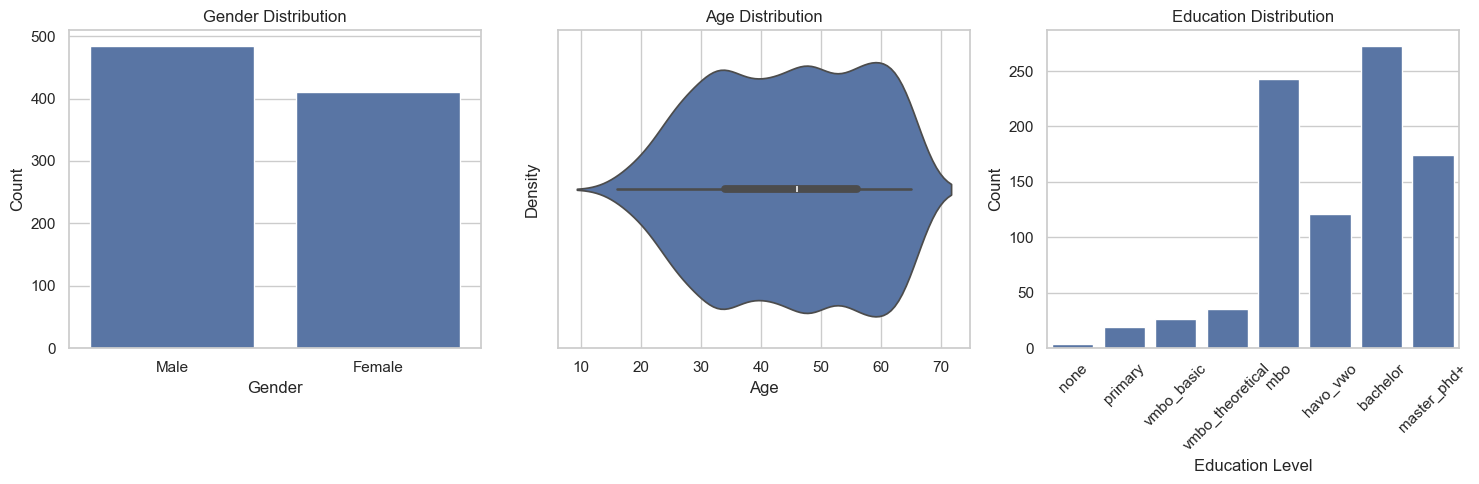

In [12]:
#PLOT DEMOGRAPHIC DISTRIBUTIONS -->>>

#set the style for APA7
sns.set(style='whitegrid')

#create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#gender distribution plot
sns.countplot(data=demogs_df, x='gender', ax=axs[0])
axs[0].set_title('Gender Distribution')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Count')

#age distribution plot
sns.violinplot(data=demogs_df, x='age', ax=axs[1])
axs[1].set_title('Age Distribution')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Density')

#education distribution plot
sorted_df = demogs_df.sort_values(by='education_level').dropna()
sns.countplot(data=sorted_df, x='education_simple', order=sorted_df['education_simple'].unique(), ax=axs[2])
axs[2].set_title('Education Distribution')
axs[2].set_xlabel('Education Level')
axs[2].set_ylabel('Count')
axs[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('demographic_distributions.png', dpi=300)

# Show the figure
plt.show()

## (3) Pre-survey
- (i) news frequency, (ii) news sources, (iii) tiktok usage, (iv) news attitudes, (v) duty to keep informed (DTKI), (vi) need for cognitive closure (NFCC)

### >> recode column names to describe measurement items: 

In [13]:
#RECODE COLUMN NAMES -->>>
news_src_col_translations = {
    "NEWS_SRC_1": "NEWS_SRC_Direct", # News Websites and Apps
    "NEWS_SRC_2": "NEWS_SRC_Social", #Social Media Websites and Apps
    "NEWS_SRC_3": "NEWS_SRC_Television", #Television Broadcasts
    "NEWS_SRC_4": "NEWS_SRC_Radio", #Radio Broadcasts
    "NEWS_SRC_5": "NEWS_SRC_Printed", #Printed Newspapers and Magazines
    "NEWS_SRC_6": "NEWS_SRC_Podcasts" #Podcasts
}

news_att_col_translations = {
    "NEWS_ATTS_1": "NEWS_ATTS_Passivity", #ambient news awareness / passivity. 
    "NEWS_ATTS_2": "NEWS_ATTS_Empowerment", #percieved empowerment / capacity to act 
    "NEWS_ATTS_3": "NEWS_ATTS_Pleasure", #hedonistic motivation / emotional gratification
    "NEWS_ATTS_4": "NEWS_ATTS_FindMe", #trust in incidental exposure / information osmosis
    "NEWS_ATTS_5": "NEWS_ATTS_Benefits", #perceived utility / value of news consumption. 
    "NEWS_ATTS_6": "NEWS_ATTS_Interest", #fundamental interest / attraction to news. 
    "NEWS_ATTS_7": "NEWS_ATTS_Reliable" #general trust in broad news environment. 
}

dkti_col_translations = {
    "DTKI_1": "DKTI_CivicDuty", # duty to stay informed as societal obligation
    "DTKI_2": "DKTI_Importance", # percieved importance of staying informed
    "DTKI_3": "DKTI_Diffusion",  # diffusion of responsibility/social loafing
    "DTKI_4": "DKTI_Dismissive" # dismissal of news importance
}

nfcc_col_translations = {
    "NFCC_1": "NFCC_Clarity", # preference for clear/unambiguous statements
    "NFCC_2": "NFCC_Avoidance", # avoidance of ambiguous/controversial discussions
    "NFCC_3": "NFCC_Openness", # comfort with open-ended problem solving
    "NFCC_4": "NFCC_Spontaneity", # appreciation of daily uncertainties/surprises
    "NFCC_5": "NFCC_Predictability" # preference for predictable situations
}

#translate column names:
pre_survey_df = pre_survey_df.rename(columns=news_src_col_translations)
pre_survey_df = pre_survey_df.rename(columns=news_att_col_translations)
pre_survey_df = pre_survey_df.rename(columns=dkti_col_translations)
pre_survey_df = pre_survey_df.rename(columns=nfcc_col_translations)


### >> recode response scale labels to integers:

In [14]:
#RECODE RESPONSE SCALE VALUES -->>>
#define scale translations: 
frequency_translations = {
    "een of twee keer per dag": 4,
    "minstens drie keer per dag": 5,
    "een paar keer per week": 3,
    "een paar keer per maand": 2,
    "minder vaak": 1,
    "nooit": 0
}

agreement_translations = {
    "Mee eens": 4,
    "Neutraal": 3,
    "Mee oneens": 2,
    "Helemaal mee oneens": 1,
    "Helemaal mee eens": 5
}

reflection_translations = {
    "Redelijk": 3,
    "Goed": 4,
    "Niet goed": 2,
    "Zeer goed": 5,
    "Helemaal niet goed": 1
}

#apply translations to whole dataframe:
pre_survey_df.replace(frequency_translations, inplace=True)
pre_survey_df.replace(agreement_translations, inplace=True)
pre_survey_df.replace(reflection_translations, inplace=True)

#preview:
pre_survey_df.head(1)

/var/folders/r1/j18tpp5j7jbdhprr5v5r918h0000gn/T/ipykernel_61953/3750240133.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pre_survey_df.replace(frequency_translations, inplace=True)
/var/folders/r1/j18tpp5j7jbdhprr5v5r918h0000gn/T/ipykernel_61953/3750240133.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pre_survey_df.replace(agreement_translations, inplace=True)
/var/folders/r1/j18tpp5j7jbdhprr5v5r918h0000gn/T/ipykernel_61953/3750240133.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be 

,NEWS_FRQ,NEWS_SRC_Direct,NEWS_SRC_Social,NEWS_SRC_Television,NEWS_SRC_Radio,NEWS_SRC_Printed,NEWS_SRC_Podcasts,TIKTOK,NEWS_ATTS_Passivity,NEWS_ATTS_Empowerment,...,NEWS_ATTS_Reliable,DKTI_CivicDuty,DKTI_Importance,DKTI_Diffusion,DKTI_Dismissive,NFCC_Clarity,NFCC_Avoidance,NFCC_Openness,NFCC_Spontaneity,NFCC_Predictability
ResponseId,,,,,,,,,,,,,,,,,,,,,
R_8kUfS95brvqi4Rj,5,5,6,1,3,4,2,5,5,5,...,5,5,5,5,5,5,5,5,5,5


### >> calculate mean aggregate scores for the `DTKI` and `NFCC` scales:

In [15]:
#CALCULATE MEAN METRICS -->>>
pre_survey_df['DTKI_AGG'] = pre_survey_df[['DKTI_CivicDuty', 'DKTI_Importance', 'DKTI_Diffusion', 'DKTI_Dismissive']].mean(axis=1)

pre_survey_df['NFCC_AGG'] = pre_survey_df[['NFCC_Clarity', 'NFCC_Avoidance', 'NFCC_Openness', 'NFCC_Spontaneity', 'NFCC_Predictability']].mean(axis=1)

#preview:
pre_survey_df.head(1)

,NEWS_FRQ,NEWS_SRC_Direct,NEWS_SRC_Social,NEWS_SRC_Television,NEWS_SRC_Radio,NEWS_SRC_Printed,NEWS_SRC_Podcasts,TIKTOK,NEWS_ATTS_Passivity,NEWS_ATTS_Empowerment,...,DKTI_Importance,DKTI_Diffusion,DKTI_Dismissive,NFCC_Clarity,NFCC_Avoidance,NFCC_Openness,NFCC_Spontaneity,NFCC_Predictability,DTKI_AGG,NFCC_AGG
ResponseId,,,,,,,,,,,,,,,,,,,,,
R_8kUfS95brvqi4Rj,5,5,6,1,3,4,2,5,5,5,...,5,5,5,5,5,5,5,5,5.0,5.0


## (4) Post-survey

In [16]:
#TRANSLATE SCALE VALUES -->>>
#define scale translations: 
likelyhood_translations = {
    "Waarschijnlijk wel": "Probably yes",
    "Misschien / Neutraal": "Maybe / Neutral",
    "Zeker wel": "Definitely yes",
    "Waarschijnlijk niet": "Probably not",
    "Zeker niet": "Definitely not"
}

#apply translations to whole dataframe:
post_survey_df.replace(likelyhood_translations, inplace=True)

#preview:
post_survey_df.head(1)

,EVAL_FAV,EVAL_FREE
ResponseId,,
R_8kUfS95brvqi4Rj,Definitely yes,geen


## (5) Selections

#### >> create `lookup_df` from HxRyRz dict: 
- this dataframe describes all potential recommendation paths through Hx, HxRy, HxRyRz (+ TITLES, + STRATEGIES).

In [17]:
def flatten_recommendation_paths(data):
    rows = []
    
    for day, day_data in data.items():
        for headline, headline_data in day_data.items():
            headline_id = headline_data['id']
            
            for first_rec, first_rec_data in headline_data.items():
                if first_rec == 'id':
                    continue
                
                first_rec_id = first_rec_data['id']
                first_rec_strategy = first_rec_data['strategy']
                
                for second_rec, second_rec_data in first_rec_data.get('recommendations', {}).items():
                    second_rec_id = second_rec_data['id']
                    second_rec_strategy = second_rec_data['strategy']
                    
                    row = { #store ids as strings to avoid integer overflow
                        'Dx': int(day),
                        'Hx': headline_id,
                        'Hx_TITLE': HxRyRz_news.loc[headline_id, 'title'],
                        'HxRy': first_rec_id,
                        'HxRy_TITLE': HxRyRz_news.loc[first_rec_id, 'title'],
                        'HxRy_STRAT': first_rec_strategy,
                        'HxRyRz': second_rec_id,
                        'HxRyRz_TITLE': HxRyRz_news.loc[second_rec_id, 'title'],
                        'HxRyRz_STRAT': second_rec_strategy
                    }
                    rows.append(row)
    
    df = pd.DataFrame(rows)
    return df

In [18]:
lookup_df = flatten_recommendation_paths(HxRyRz_recs)
print(lookup_df.shape)
lookup_df.head(1)

(400, 9)


,Dx,Hx,Hx_TITLE,HxRy,HxRy_TITLE,HxRy_STRAT,HxRyRz,HxRyRz_TITLE,HxRyRz_STRAT
0,1,5491104466804203330,Moskou heeft nog geen antwoord op Oekraïense i...,5707263832351023063,"Massa-evacuatie in grensregio Koersk, Zelensky...",similarity_recs,4581299747256522632,Oekraïne beperkt bewegingsvrijheid in grensgeb...,similarity_recs


#### >> simplify `nrs_selections_df` by truncating column names:
- this describes the actual paths taken by each participant (by TITLES only).

In [19]:
nrs_selections_df.head(1)

,HEAD_CHOICE,HEAD_CHOICE_DO,H1_SELECT,H1_SELECT_DO,H1R1_SELECT,H1R1_SELECT_DO,H1R2_SELECT,H1R2_SELECT_DO,H1R3_SELECT,H1R3_SELECT_DO,...,H5_SELECT,H5_SELECT_DO,H5R1_SELECT,H5R1_SELECT_DO,H5R2_SELECT,H5R2_SELECT_DO,H5R3_SELECT,H5R3_SELECT_DO,H5R4_SELECT,H5R4_SELECT_DO
ResponseId,,,,,,,,,,,,,,,,,,,,,
R_8kUfS95brvqi4Rj,Groot aantal doden gemeld bij Israëlische luch...,Groot aantal doden gemeld bij Israëlische luch...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#SPECIAL: drop the choice order (DO) columns for now, return later to investigate position bias on Hx|Ry|Rz selections (optional).
nrs_selections_df = nrs_selections_df.drop(columns=[col for col in nrs_selections_df.columns if 'DO' in col])

In [21]:
def shorten_nrs_selections_df(nrs_selections_df):
    #repacement columns: 
    new_columns = ['Hx_TITLE', 'HxRy_TITLE', 'HxRyRz_TITLE']
    #create a new DataFrame with the same index and new columns:
    shortened_df = pd.DataFrame(index=nrs_selections_df.index, columns=new_columns)
    #iterate over each row in the original DataFrame
    for idx, row in nrs_selections_df.iterrows():
        #get the non-NaN values (SANITY: 3 choices)
        non_nan_values = row.dropna().values.tolist()
        assert len(non_nan_values) == 3
        #assign the non-NaN values to the new columns:
        shortened_df.loc[idx, new_columns] = non_nan_values
    
    return shortened_df

nrs_selections_df = shorten_nrs_selections_df(nrs_selections_df)
nrs_selections_df['Dx'] = metrics_df['study_day'] #add Dx for next step (lookup)
nrs_selections_df.head(1)

,Hx_TITLE,HxRy_TITLE,HxRyRz_TITLE,Dx
ResponseId,,,,
R_8kUfS95brvqi4Rj,Groot aantal doden gemeld bij Israëlische luch...,Niet alleen Iron Dome moet gevreesd ’zwarte wo...,Maden in je containers? Dit kun je ertegen doen,1


#### >> merge strategies from `lookup_df` onto `nrs_selections_df`:
- enriches the participant path descriptions with article IDs, TITLES, and STRATEGIES.

In [22]:
#MERGE STRATEGIES ONTO USER PATHS -->>>
#reset the index to store the ResponseId as a column
nrs_selections_df = nrs_selections_df.reset_index()

# Merge strategies onto user paths based on matching Dx, Hx_TITLE, HxRy_TITLE, and HxRyRz_TITLE
nrs_selections_df = nrs_selections_df.merge(
    lookup_df,
    on=['Dx', 'Hx_TITLE', 'HxRy_TITLE', 'HxRyRz_TITLE'],
    how='left'
)

# Set the index back to the original index column
nrs_selections_df = nrs_selections_df.set_index('ResponseId')

# Report the number of duplicated indexes
duplicated_indexes = nrs_selections_df.index.duplicated()
num_duplicated_indexes = duplicated_indexes.sum()
print(f"Number of duplicated indexes: {num_duplicated_indexes}")

# Drop duplicated indexes
print("Dropping duplicated indexes (these stem from two strategies yielding the same recommendation, making these cases ambiguous...)...")
nrs_selections_df = nrs_selections_df[~duplicated_indexes]

nrs_selections_df.head(1)


Number of duplicated indexes: 3
Dropping duplicated indexes (these stem from two strategies yielding the same recommendation, making these cases ambiguous...)...


,Hx_TITLE,HxRy_TITLE,HxRyRz_TITLE,Dx,Hx,HxRy,HxRy_STRAT,HxRyRz,HxRyRz_STRAT
ResponseId,,,,,,,,,
R_8kUfS95brvqi4Rj,Groot aantal doden gemeld bij Israëlische luch...,Niet alleen Iron Dome moet gevreesd ’zwarte wo...,Maden in je containers? Dit kun je ertegen doen,1,6469266472911271489,215718117841851186,subject_pivot_recs,1506619606376679929,random_recs


## (6) Rankings

#### >> simplify `nrs_rankings_df` by truncating column naming:
- reduce 375 columns to 30 by factoring (e.g., H1R2 and HxRy --> HxRy)

In [23]:
#SPECIAL: drop the choice order (DO) columns for now, return later to investigate position bias on Hx|Ry|Rz rankings
nrs_rankings_df = nrs_rankings_df.drop(columns=[col for col in nrs_rankings_df.columns if 'DO' in col])

In [24]:
def shorten_nrs_rankings_df(nrs_rankings_df):
    
    #truncated columns:  
    new_columns = [
        'HxRy_RANK1_1', 'HxRy_RANK1_2', 'HxRy_RANK1_3', 'HxRy_RANK1_4', 
        'HxRy_RANK2_1', 'HxRy_RANK2_2', 'HxRy_RANK2_3', 'HxRy_RANK2_4', 
        'HxRy_RANK3_1', 'HxRy_RANK3_2', 'HxRy_RANK3_3', 'HxRy_RANK3_4', 
        'HxRyRz_RANK1_1', 'HxRyRz_RANK1_2', 'HxRyRz_RANK1_3', 'HxRyRz_RANK1_4', 'HxRyRz_RANK1_5',
        'HxRyRz_RANK2_1', 'HxRyRz_RANK2_2', 'HxRyRz_RANK2_3', 'HxRyRz_RANK2_4',
        'HxRyRz_RANK3_1', 'HxRyRz_RANK3_2', 'HxRyRz_RANK3_3', 'HxRyRz_RANK3_4',
    ]
    
    #create a new DataFrame with the same index and new columns:
    shortened_df = pd.DataFrame(index=nrs_rankings_df.index, columns=new_columns)
    
    #iterate over each row in the original DataFrame
    for idx, row in nrs_rankings_df.iterrows():
        #get the non-NaN values (SANITY: 12+12)
        non_nan_values = row.dropna().values.tolist()
        assert len(non_nan_values) == 25
        #assign the non-NaN values to the new columns:
        shortened_df.loc[idx, new_columns] = non_nan_values
    
    return shortened_df

In [25]:
nrs_rankings_df = shorten_nrs_rankings_df(nrs_rankings_df)
nrs_rankings_df = nrs_rankings_df.apply(pd.to_numeric, errors='ignore')
nrs_rankings_df.head(1)

/var/folders/r1/j18tpp5j7jbdhprr5v5r918h0000gn/T/ipykernel_61953/895787503.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  nrs_rankings_df = nrs_rankings_df.apply(pd.to_numeric, errors='ignore')


,HxRy_RANK1_1,HxRy_RANK1_2,HxRy_RANK1_3,HxRy_RANK1_4,HxRy_RANK2_1,HxRy_RANK2_2,HxRy_RANK2_3,HxRy_RANK2_4,HxRy_RANK3_1,HxRy_RANK3_2,...,HxRyRz_RANK1_4,HxRyRz_RANK1_5,HxRyRz_RANK2_1,HxRyRz_RANK2_2,HxRyRz_RANK2_3,HxRyRz_RANK2_4,HxRyRz_RANK3_1,HxRyRz_RANK3_2,HxRyRz_RANK3_3,HxRyRz_RANK3_4
ResponseId,,,,,,,,,,,,,,,,,,,,,
R_8kUfS95brvqi4Rj,3,4,2,1,4,1,2,3,4,1,...,3,4,2,4,3,1,3,2,4,1


### >> rename columns so that they descibe the dimension and strategy being ranked: 

In [26]:
#RENAME RANKING COLUMNS -->>>
a_map = {'1': 'REL', '2': 'UNX', '3': 'SAT'}
b_map = {'1': 'SIM', '2': 'SUB', '3': 'CON', '4': 'RAN', '5': 'CTL'}

# Function to recode column names
def recode_columns(df):
    new_columns = {}
    for col in df.columns:
        # Match patterns with any prefix ending with '_RANK', followed by digits
        match = re.match(r'(.*)_RANK(\d+)_(\d+)$', col)
        if match:
            prefix = match.group(1)
            a = match.group(2)
            b = match.group(3)
            # Replace 'a' and 'b' according to the mappings
            a_new = a_map.get(a, a)
            b_new = b_map.get(b, b)
            new_col = f"{prefix}_{a_new}_{b_new}"
            new_columns[col] = new_col
    # Rename the columns
    df = df.rename(columns=new_columns)
    return df

# Apply the function to your DataFrame
nrs_rankings_df = recode_columns(nrs_rankings_df)

#preview:
nrs_rankings_df.head(1)

,HxRy_REL_SIM,HxRy_REL_SUB,HxRy_REL_CON,HxRy_REL_RAN,HxRy_UNX_SIM,HxRy_UNX_SUB,HxRy_UNX_CON,HxRy_UNX_RAN,HxRy_SAT_SIM,HxRy_SAT_SUB,...,HxRyRz_REL_RAN,HxRyRz_REL_CTL,HxRyRz_UNX_SIM,HxRyRz_UNX_SUB,HxRyRz_UNX_CON,HxRyRz_UNX_RAN,HxRyRz_SAT_SIM,HxRyRz_SAT_SUB,HxRyRz_SAT_CON,HxRyRz_SAT_RAN
ResponseId,,,,,,,,,,,,,,,,,,,,,
R_8kUfS95brvqi4Rj,3,4,2,1,4,1,2,3,4,1,...,3,4,2,4,3,1,3,2,4,1


## (7) Justifications

In [27]:
def shorten_nrs_justifications_df(nrs_justifications_df):
    
    #repacement columns: 
    new_columns = ['HxRy_JUSTIFY', 'HxRyRz_JUSTIFY']
    
    #create a new DataFrame with the same index and new columns:
    shortened_df = pd.DataFrame(index=nrs_justifications_df.index, columns=new_columns)
    
    #iterate over each row in the original DataFrame
    for idx, row in nrs_justifications_df.iterrows():
        #get the non-NaN values (always: 12+12+6)
        non_nan_values = row.dropna().values.tolist()
        assert len(non_nan_values) == 2
        #assign the non-NaN values to the new columns:
        shortened_df.loc[idx, new_columns] = non_nan_values
    
    return shortened_df

In [28]:
nrs_justifications_df = shorten_nrs_justifications_df(nrs_justifications_df)
nrs_justifications_df.head()

,HxRy_JUSTIFY,HxRyRz_JUSTIFY
ResponseId,,
R_8kUfS95brvqi4Rj,geen,geen
R_2rArkVRvjcq99QG,Ik ben goed op de hoogte van alle nieuws rondo...,"Wat voor complotdenkers geldt, geldt waarschij..."
R_8p3RYDHqCCYjeXD,Het heeft een tegenargument en ik vindt het si...,Ik ben heel erg geïnteresseerd in buitenlandse...
R_2rcaZdxcfm07cSr,Interessantst,Interessant
R_2OIX5LW9lQFV65X,meest intresant,maakt me het meest nieuwsgierig


## (8) Model ready: 

### Remove participants who failed the attention check:

In [29]:
# REPORT ATTENTION CHECK PASS RATE AND DROP FAILS -->>>
total_count = nrs_rankings_df['HxRyRz_REL_CTL'].count()
count_of_5 = nrs_rankings_df['HxRyRz_REL_CTL'].value_counts().get(5)
print(f"{int(round(count_of_5 / total_count, 2)*100)}% of participants ({count_of_5} of {total_count}) passed the attention check.")

# Get the list of participants who failed the attention check
failed_attention_check = nrs_rankings_df[nrs_rankings_df['HxRyRz_REL_CTL'] != 5].index.tolist()

# Drop the participants who failed the attention check:
data_df = data_df[~data_df.index.isin(failed_attention_check)]
#demogs_df = demogs_df[~demogs_df.index.isin(failed_attention_check)]    
metrics_df = metrics_df[~metrics_df.index.isin(failed_attention_check)]
consent_df = consent_df[~consent_df.index.isin(failed_attention_check)]
pre_survey_df = pre_survey_df[~pre_survey_df.index.isin(failed_attention_check)]
post_survey_df = post_survey_df[~post_survey_df.index.isin(failed_attention_check)]
nrs_selections_df = nrs_selections_df[~nrs_selections_df.index.isin(failed_attention_check)]
nrs_rankings_df = nrs_rankings_df[~nrs_rankings_df.index.isin(failed_attention_check)]
nrs_justifications_df =nrs_justifications_df[~nrs_justifications_df.index.isin(failed_attention_check)]

#assert that all dataframes have the same number of rows:
assert len(metrics_df) == len(consent_df) == len(pre_survey_df) == len(post_survey_df) == len(nrs_selections_df) == len(nrs_rankings_df) == len(nrs_justifications_df)

print(f"Number of participants remaining after attention check: {len(metrics_df)}...")

#now drop the attention check column:
nrs_rankings_df = nrs_rankings_df.drop(columns=['HxRyRz_REL_CTL'])

87% of participants (732 of 837) passed the attention check.
Number of participants remaining after attention check: 732...


### Get transition pairs and calculate distances and pivot strength metrics.

In [30]:
# Extract ids pairs (1e,2e) for each recommendation strategy:
def extract_strategy_transitions(HxRyRz_recs):
    """
    Extract transition pairs (from_id, to_id) organized by recommendation strategy.
    
    Returns:
        dict: Four lists of tuples for each strategy type
    """
    strategy_transitions = {
        'similarity_recs': [],
        'subject_pivot_recs': [],
        'context_pivot_recs': [],
        'random_recs': []
    }
    
    for day, headlines in HxRyRz_recs.items():
        if day == 'id':  # Skip the top-level id
            continue
            
        for headline_key, headline_data in headlines.items():
            if headline_key == 'id':  # Skip headline id
                continue
                
            headline_id = headline_data['id']
            
            # Process first-level recommendations (H1R1, H1R2, etc.)
            for rec_key, rec_data in headline_data.items():
                if rec_key == 'id':  # Skip headline id
                    continue
                    
                first_rec_id = rec_data['id']
                first_rec_strategy = rec_data['strategy']
                
                # Add headline → first rec transition
                strategy_transitions[first_rec_strategy].append((headline_id, first_rec_id))
                
                # Process second-level recommendations (H1R1R1, H1R1R2, etc.)
                for second_rec_key, second_rec_data in rec_data['recommendations'].items():
                    second_rec_id = second_rec_data['id']
                    second_rec_strategy = second_rec_data['strategy']
                    
                    # Add first rec → second rec transition
                    strategy_transitions[second_rec_strategy].append((first_rec_id, second_rec_id))
    
    return strategy_transitions
transitions = extract_strategy_transitions(HxRyRz_recs)
for strategy, transition_list in transitions.items():
    print(f"{strategy}: collected IDs for {len(transition_list)} transitions")

# Calculate document(3e), subject(4e), and context(5e) distances:
def calculate_distances(transitions, HxRyRz_news):
    """
    Calculate semantic distances for document transitions and add as third element to tuples.
    Also calculates subject and context distances as fourth and fifth elements.
    Returns raw distances without normalization.
    
    Args:
        transitions: Dict with strategy keys and lists of (from_id, to_id) tuples
        HxRyRz_news: DataFrame with 'id', 'document_embedding', 'subject_embedding', 'context_embedding' columns
    
    Returns:
        Dict with strategy keys and lists of (from_id, to_id, doc_distance, subject_distance, context_distance) tuples
    """
    # Create lookup dictionaries for embeddings
    doc_embedding_lookup = HxRyRz_news['document_embedding'].to_dict()
    subject_embedding_lookup = HxRyRz_news['subject_embedding'].to_dict()
    context_embedding_lookup = HxRyRz_news['context_embedding'].to_dict()
    
    # Calculate raw distances for all transitions
    all_doc_distances = []
    all_subject_distances = []
    all_context_distances = []
    raw_transitions = {}
    
    for strategy, transition_list in transitions.items():
        raw_transitions[strategy] = []
        
        for from_id, to_id in transition_list:
            # Get embeddings for both documents
            from_doc_embedding = doc_embedding_lookup[from_id]
            to_doc_embedding = doc_embedding_lookup[to_id]
            from_subject_embedding = subject_embedding_lookup[from_id]
            to_subject_embedding = subject_embedding_lookup[to_id]
            from_context_embedding = context_embedding_lookup[from_id]
            to_context_embedding = context_embedding_lookup[to_id]
            
            # Calculate cosine similarities first (reshape for sklearn)
            from_doc_emb = np.array(from_doc_embedding).reshape(1, -1)
            to_doc_emb = np.array(to_doc_embedding).reshape(1, -1)
            doc_similarity = cosine_similarity(from_doc_emb, to_doc_emb)[0, 0]
            
            from_subject_emb = np.array(from_subject_embedding).reshape(1, -1)
            to_subject_emb = np.array(to_subject_embedding).reshape(1, -1)
            subject_similarity = cosine_similarity(from_subject_emb, to_subject_emb)[0, 0]
            
            from_context_emb = np.array(from_context_embedding).reshape(1, -1)
            to_context_emb = np.array(to_context_embedding).reshape(1, -1)
            context_similarity = cosine_similarity(from_context_emb, to_context_emb)[0, 0]
            
            # Convert similarities to distances (1 - similarity)
            doc_distance = 1 - doc_similarity
            subject_distance = 1 - subject_similarity
            context_distance = 1 - context_similarity
            
            raw_transitions[strategy].append((from_id, to_id, doc_distance, subject_distance, context_distance))
            all_doc_distances.append(doc_distance)
            all_subject_distances.append(subject_distance)
            all_context_distances.append(context_distance)
    
    # Calculate global ranges for reporting (but don't normalize)
    doc_min, doc_max = min(all_doc_distances), max(all_doc_distances)
    subject_min, subject_max = min(all_subject_distances), max(all_subject_distances)
    context_min, context_max = min(all_context_distances), max(all_context_distances)
    
    print(f"Global document distance range: {doc_min:.4f} to {doc_max:.4f}")
    print(f"Global subject distance range: {subject_min:.4f} to {subject_max:.4f}")
    print(f"Global context distance range: {context_min:.4f} to {context_max:.4f}")
    
    # Report statistics for each strategy (using raw distances)
    print("\nCosine distance calculation summary:")
    print("-" * 50)
    for strategy, transition_list in raw_transitions.items():
        doc_dists = [doc_dist for _, _, doc_dist, _, _ in transition_list]
        subject_dists = [subject_dist for _, _, _, subject_dist, _ in transition_list]
        context_dists = [context_dist for _, _, _, _, context_dist in transition_list]
        
        print(f"{strategy}:")
        print(f"  Valid values: {len(doc_dists)}")
        print(f"  Mean document distance: {np.mean(doc_dists):.4f}, SD: {np.std(doc_dists):.4f}")
        print(f"  Mean subject distance: {np.mean(subject_dists):.4f}, SD: {np.std(subject_dists):.4f}")
        print(f"  Mean context distance: {np.mean(context_dists):.4f}, SD: {np.std(context_dists):.4f}")
        print(f"  Doc range: {min(doc_dists):.4f} to {max(doc_dists):.4f}")
        print(f"  Subject range: {min(subject_dists):.4f} to {max(subject_dists):.4f}")
        print(f"  Context range: {min(context_dists):.4f} to {max(context_dists):.4f}")
        print()
    
    return raw_transitions
transitions = calculate_distances(transitions, HxRyRz_news)

# Calculate normalized pivot scores (6e):
def calculate_pivot(transitions):
    """
    Add pivot scores as sixth element to existing transition tuples.
    Normalizes pivot scores to 0-1 scale across all strategies for comparability.
    
    Args:
        transitions: Dict with strategy keys and lists of (from_id, to_id, doc_distance, subject_distance, context_distance) tuples
    
    Returns:
        Dict with strategy keys and lists of (from_id, to_id, doc_distance, subject_distance, context_distance, normalized_pivot_score) tuples
    """
    # pivot parameters
    beta = 3.0
    gamma = 1.2
    
    def calculate_pivot_score(subject_sim, context_sim, strategy):
        """Calculate pivot score based on strategy."""
        if strategy == 'subject_pivot_recs':
            # M = subject similarity, m = context similarity
            return (subject_sim ** beta) * ((1 - context_sim) ** gamma)
        elif strategy == 'context_pivot_recs':
            # M = context similarity, m = subject similarity
            return (context_sim ** beta) * ((1 - subject_sim) ** gamma)
        else:  # similarity_recs or random_recs
            # Calculate both ways and take maximum
            subject_pivot_score = (subject_sim ** beta) * ((1 - context_sim) ** gamma)
            context_pivot_score = (context_sim ** beta) * ((1 - subject_sim) ** gamma)
            return max(subject_pivot_score, context_pivot_score)
    
    # First pass: calculate all raw pivot scores
    all_pivot_scores = []
    raw_transitions = {}
    
    for strategy, transition_list in transitions.items():
        raw_transitions[strategy] = []
        
        for from_id, to_id, doc_distance, subject_distance, context_distance in transition_list:
            # Convert distances back to similarities for pivot calculation
            subject_similarity = 1 - subject_distance
            context_similarity = 1 - context_distance
            
            # Calculate pivot score using similarities
            pivot_score = calculate_pivot_score(subject_similarity, context_similarity, strategy)
            
            raw_transitions[strategy].append((from_id, to_id, doc_distance, subject_distance, context_distance, pivot_score))
            all_pivot_scores.append(pivot_score)
    
    # Calculate global min and max for normalization
    global_min = min(all_pivot_scores)
    global_max = max(all_pivot_scores)
    ff_range = global_max - global_min
    
    print(f"Global pivot range: {global_min:.4f} to {global_max:.4f}")
    
    # Second pass: normalize pivot scores to 0-1 scale
    normalized_transitions = {}
    
    for strategy, transition_list in raw_transitions.items():
        normalized_transitions[strategy] = []
        
        for from_id, to_id, doc_distance, subject_distance, context_distance, raw_ff_score in transition_list:
            # Normalize to 0-1 scale
            if ff_range > 0:
                normalized_ff_score = (raw_ff_score - global_min) / ff_range
            else:
                normalized_ff_score = 0.0
            
            normalized_transitions[strategy].append((from_id, to_id, doc_distance, subject_distance, context_distance, normalized_ff_score))
    
    # Report statistics for each strategy
    print("\nNormalized pivot calculation summary:")
    print("-" * 50)
    for strategy, transition_list in normalized_transitions.items():
        ff_scores = [ff for _, _, _, _, _, ff in transition_list]
        print(f"{strategy}:")
        print(f"  Valid values: {len(ff_scores)}")
        print(f"  Mean pivot: {np.mean(ff_scores):.4f}, SD: {np.std(ff_scores):.4f}")
        print(f"  Range: {min(ff_scores):.4f} to {max(ff_scores):.4f}")
        print()
    
    return normalized_transitions
transitions = calculate_pivot(transitions)

similarity_recs: collected IDs for 125 transitions
subject_pivot_recs: collected IDs for 125 transitions
context_pivot_recs: collected IDs for 125 transitions
random_recs: collected IDs for 125 transitions
Global document distance range: 0.0151 to 0.7521
Global subject distance range: 0.0190 to 1.0657
Global context distance range: 0.0093 to 0.6963

Cosine distance calculation summary:
--------------------------------------------------
similarity_recs:
  Valid values: 125
  Mean document distance: 0.1012, SD: 0.0655
  Mean subject distance: 0.1475, SD: 0.1479
  Mean context distance: 0.1445, SD: 0.0999
  Doc range: 0.0151 to 0.2912
  Subject range: 0.0190 to 0.9313
  Context range: 0.0093 to 0.5177

subject_pivot_recs:
  Valid values: 125
  Mean document distance: 0.2760, SD: 0.0922
  Mean subject distance: 0.1412, SD: 0.1035
  Mean context distance: 0.3005, SD: 0.1399
  Doc range: 0.1029 to 0.4908
  Subject range: 0.0262 to 0.8668
  Context range: 0.0619 to 0.6963

context_pivot_recs:

### Create model-ready dataframe (data for all models)

In [31]:
def create_model_dataframe(nrs_selections_df, nrs_rankings_df, HxRyRz_recs, transitions):
    """
    Create the dataframe for ordinal regression models by integrating all data sources.
    Returns dataframe with 8 rows per user (2 rounds × 4 strategies).
    Rankings are reversed so higher values = better performance (4=best, 3, 2, 1=worst).
    
    Args:
        nrs_selections_df: DataFrame with user selections (Dx, Hx, HxRy, HxRyRz columns)
        nrs_rankings_df: DataFrame with user rankings (columns like HxRy_REL_SIM, etc.)
        HxRyRz_recs: Dict with recommendation structure by day
        transitions: Dict with transition data including distances and pivot scores
        
    Returns:
        DataFrame ready for ordinal regression modeling with reversed rankings
    """
    
    # Strategy mappings
    strategy_mapping = {
        'similarity_recs': 'SIM',
        'subject_pivot_recs': 'SUB', 
        'context_pivot_recs': 'CON',
        'random_recs': 'RAN'
    }

    # Create lookup dictionary for article positions (day, article_id) -> position_key
    print("Creating position lookup dictionary...")
    id_to_position_lookup = {}
    for day, day_data in HxRyRz_recs.items():
        if day == 'id':
            continue
        for position_key, position_data in day_data.items():
            if position_key == 'id':
                continue
            article_id = position_data['id']
            id_to_position_lookup[(day, article_id)] = position_key
    
    print(f"Created position lookup for {len(id_to_position_lookup)} articles across all days")
    
    # Create lookup dictionary for transitions (from_id, to_id) -> transition_data
    # Scale both document distance and pivot scores to 0-1 range
    print("Creating transition lookup dictionary...")
    
    # First, collect all scores to find min/max for scaling
    all_doc_distances = []
    all_ff_scores = []
    for strategy, transition_list in transitions.items():
        for from_id, to_id, doc_distance, subject_distance, context_distance, pivot in transition_list:
            all_doc_distances.append(doc_distance)
            all_ff_scores.append(pivot)
    
    # Calculate scaling parameters
    doc_min, doc_max = min(all_doc_distances), max(all_doc_distances)
    doc_range = doc_max - doc_min
    
    ff_min, ff_max = min(all_ff_scores), max(all_ff_scores)
    ff_range = ff_max - ff_min
    
    print(f"Document distance range: {doc_min:.4f} to {doc_max:.4f}")
    print(f"pivot score range: {ff_min:.4f} to {ff_max:.4f}")
    
    # Create transition lookup with scaled values
    transition_lookup = {}
    for strategy, transition_list in transitions.items():
        for from_id, to_id, doc_distance, subject_distance, context_distance, pivot in transition_list:
            # Scale document distance to 0-1
            if doc_range > 0:
                scaled_doc_distance = (doc_distance - doc_min) / doc_range
            else:
                scaled_doc_distance = 0.0
            
            # Scale pivot to 0-1
            if ff_range > 0:
                scaled_ff = (pivot - ff_min) / ff_range
            else:
                scaled_ff = 0.0
                
            transition_lookup[(from_id, to_id)] = {
                'doc_distance': scaled_doc_distance,
                'pivot': scaled_ff,
                'strategy': strategy
            }
    
    print(f"Created lookup for {len(transition_lookup)} transitions")
    
    # Initialize list to store all rows
    data_rows = []
    missing_transitions = []
    
    print("Processing users...")
    
    # Process each user
    for user_idx, user_row in nrs_selections_df.iterrows():
        user_id = user_idx
        study_day = user_row['Dx']
        initial_article = int(user_row['Hx'])
        first_selection = int(user_row['HxRy'])
        second_selection = int(user_row['HxRyRz'])
        
        # Get recommendations for this user from HxRyRz_recs
        try:
            user_day_data = HxRyRz_recs[study_day]
        except KeyError:
            print(f"Warning: Study day {study_day} not found in HxRyRz_recs for user {user_id}")
            continue
        
        # Round 1: From initial article to first selection candidates
        initial_position_key = id_to_position_lookup.get((study_day, initial_article))
        if not initial_position_key:
            print(f"Warning: Initial article {initial_article} not found in day {study_day} for user {user_id}")
            continue
            
        try:
            round_1_recs = user_day_data[initial_position_key]
            initial_article_id = round_1_recs['id']
        except KeyError:
            print(f"Warning: Position {initial_position_key} not found for user {user_id}")
            continue
        
        # Process each of the 4 first-level recommendations and track which was selected
        selected_rec_key = None
        for rec_key, rec_data in round_1_recs.items():
            if rec_key == 'id':  # Skip the id field
                continue
                
            target_id = rec_data['id']
            strategy = rec_data['strategy']
            
            # Check if this was selected and store the rec_key for Round 2
            if target_id == first_selection:
                selected_rec_key = rec_key
            
            # Look up transition data
            transition_key = (initial_article_id, target_id)
            if transition_key in transition_lookup:
                transition_data = transition_lookup[transition_key]
                
                # Look up rankings for all dimensions
                try:
                    rel_ranking_orig = nrs_rankings_df.loc[user_id, f'HxRy_REL_{strategy_mapping[strategy]}']
                    unx_ranking_orig = nrs_rankings_df.loc[user_id, f'HxRy_UNX_{strategy_mapping[strategy]}']
                    sat_ranking_orig = nrs_rankings_df.loc[user_id, f'HxRy_SAT_{strategy_mapping[strategy]}']
                    
                    # Reverse rankings: Original 1=best,4=worst → New 4=best,1=worst
                    rel_ranking_reversed = 5 - rel_ranking_orig
                    unx_ranking_reversed = 5 - unx_ranking_orig
                    sat_ranking_reversed = 5 - sat_ranking_orig
                    
                except KeyError as e:
                    print(f"Warning: Missing ranking column for user {user_id}: {e}")
                    continue
                
                # Check if this was selected
                is_selected = (target_id == first_selection)
                
                # Create row with reversed rankings
                row = {
                    'participant_id': user_id,
                    'round': 1,
                    'initial_article': initial_article,
                    'recommendation_type': strategy,
                    'from_article_id': initial_article_id,
                    'to_article_id': target_id,
                    'document_distance': transition_data['doc_distance'],
                    'pivot_score': transition_data['pivot'],
                    'rel_rank_reversed': rel_ranking_reversed,
                    'unx_rank_reversed': unx_ranking_reversed,
                    'sat_rank_reversed': sat_ranking_reversed,
                    'selected': int(is_selected)
                }
                data_rows.append(row)
            else:
                missing_transitions.append(f"Round 1: {transition_key} (user {user_id})")
        
        # Round 2: From first selection to second selection candidates
        if not selected_rec_key:
            print(f"Warning: Could not find which recommendation was selected for first selection {first_selection} for user {user_id}")
            continue
            
        try:
            # Access the recommendations from the selected first-level recommendation
            round_2_recs = round_1_recs[selected_rec_key]['recommendations']
            first_selection_id = round_1_recs[selected_rec_key]['id']  # This should equal first_selection
        except KeyError:
            print(f"Warning: Could not access recommendations for {selected_rec_key} for user {user_id}")
            continue
        
        # Process each of the 4 second-level recommendations
        for rec_key, rec_data in round_2_recs.items():
            target_id = rec_data['id']
            strategy = rec_data['strategy']
            
            # Look up transition data
            transition_key = (first_selection_id, target_id)
            if transition_key in transition_lookup:
                transition_data = transition_lookup[transition_key]
                
                # Look up rankings for all dimensions
                try:
                    rel_ranking_orig = nrs_rankings_df.loc[user_id, f'HxRyRz_REL_{strategy_mapping[strategy]}']
                    unx_ranking_orig = nrs_rankings_df.loc[user_id, f'HxRyRz_UNX_{strategy_mapping[strategy]}']
                    sat_ranking_orig = nrs_rankings_df.loc[user_id, f'HxRyRz_SAT_{strategy_mapping[strategy]}']
                    
                    # Reverse rankings: Original 1=best,4=worst → New 4=best,1=worst
                    rel_ranking_reversed = 5 - rel_ranking_orig
                    unx_ranking_reversed = 5 - unx_ranking_orig
                    sat_ranking_reversed = 5 - sat_ranking_orig
                    
                except KeyError as e:
                    print(f"Warning: Missing ranking column for user {user_id}: {e}")
                    continue
                
                # Check if this was selected
                is_selected = (target_id == second_selection)
                
                # Create row with reversed rankings
                row = {
                    'participant_id': user_id,
                    'round': 2,
                    'initial_article': initial_article,
                    'recommendation_type': strategy,
                    'from_article_id': first_selection_id,
                    'to_article_id': target_id,
                    'document_distance': transition_data['doc_distance'],
                    'pivot_score': transition_data['pivot'],
                    'rel_rank_reversed': rel_ranking_reversed,
                    'unx_rank_reversed': unx_ranking_reversed,
                    'sat_rank_reversed': sat_ranking_reversed,
                    'selected': int(is_selected)
                }
                data_rows.append(row)
            else:
                missing_transitions.append(f"Round 2: {transition_key} (user {user_id})")
    
    # Convert to DataFrame
    df = pd.DataFrame(data_rows)
    
    # Print summary statistics
    print("\nData Integration Summary:")
    print("=" * 50)
    print(f"Total rows created: {len(df)}")
    if len(df) > 0:
        print(f"Unique participants: {df['participant_id'].nunique()}")
        print(f"Expected total participants: {len(nrs_selections_df)}")
        print(f"Rows per participant: {len(df) / df['participant_id'].nunique():.1f}")
        
        print(f"\nRound distribution:")
        print(df['round'].value_counts().sort_index())
        
        print(f"\nStrategy distribution:")
        print(df['recommendation_type'].value_counts())
        
        print(f"\nSelection distribution:")
        print(f"Selected recommendations: {df['selected'].sum()}")
        print(f"Expected selections: {len(nrs_selections_df) * 2}")  # 2 selections per user
        
        print(f"\nMissing values check:")
        missing_counts = df.isnull().sum()
        if missing_counts.sum() == 0:
            print("No missing values found ✓")
        else:
            print(missing_counts[missing_counts > 0])
        
        print(f"\nDocument distance range: {df['document_distance'].min():.4f} to {df['document_distance'].max():.4f}")
        print(f"pivot range: {df['pivot_score'].min():.4f} to {df['pivot_score'].max():.4f}")
        
        # Show ranking reversal summary
        print(f"\nRanking Reversal Summary:")
        print(f"New scale: 4=best, 3, 2, 1=worst (reversed from original)")
        print(f"Relevance rankings: {df['rel_rank_reversed'].min():.0f} to {df['rel_rank_reversed'].max():.0f}, mean = {df['rel_rank_reversed'].mean():.2f}")
        print(f"Unexpectedness rankings: {df['unx_rank_reversed'].min():.0f} to {df['unx_rank_reversed'].max():.0f}, mean = {df['unx_rank_reversed'].mean():.2f}")
        print(f"Satisfaction rankings: {df['sat_rank_reversed'].min():.0f} to {df['sat_rank_reversed'].max():.0f}, mean = {df['sat_rank_reversed'].mean():.2f}")
    else:
        print("Warning: No rows created - check data compatibility")
    
    if missing_transitions:
        print(f"\nWarning: {len(missing_transitions)} transitions not found in lookup")
        if len(missing_transitions) <= 10:
            print("Missing transitions:")
            for mt in missing_transitions:
                print(f"  {mt}")
        else:
            print(f"First 10 missing transitions:")
            for mt in missing_transitions[:10]:
                print(f"  {mt}")
    
    return df
model_df = create_model_dataframe(nrs_selections_df, nrs_rankings_df, HxRyRz_recs, transitions)
model_df.head(3)

Creating position lookup dictionary...
Created position lookup for 25 articles across all days
Creating transition lookup dictionary...
Document distance range: 0.0151 to 0.7521
pivot score range: 0.0000 to 1.0000
Created lookup for 491 transitions
Processing users...

Data Integration Summary:
Total rows created: 5856
Unique participants: 732
Expected total participants: 732
Rows per participant: 8.0

Round distribution:
round
1    2928
2    2928
Name: count, dtype: int64

Strategy distribution:
recommendation_type
similarity_recs       1464
subject_pivot_recs    1464
context_pivot_recs    1464
random_recs           1464
Name: count, dtype: int64

Selection distribution:
Selected recommendations: 1467
Expected selections: 1464

Missing values check:
No missing values found ✓

Document distance range: 0.0000 to 1.0000
pivot range: 0.0000 to 1.0000

Ranking Reversal Summary:
New scale: 4=best, 3, 2, 1=worst (reversed from original)
Relevance rankings: 1 to 4, mean = 2.50
Unexpectedness 

,participant_id,round,initial_article,recommendation_type,from_article_id,to_article_id,document_distance,pivot_score,rel_rank_reversed,unx_rank_reversed,sat_rank_reversed,selected
0,R_2rArkVRvjcq99QG,1,6469266472911271489,similarity_recs,6469266472911271489,836018025033834966,0.046522,0.537527,4,1,4,0
1,R_2rArkVRvjcq99QG,1,6469266472911271489,subject_pivot_recs,6469266472911271489,215718117841851186,0.383154,0.143620,3,2,2,0
2,R_2rArkVRvjcq99QG,1,6469266472911271489,context_pivot_recs,6469266472911271489,6009968526410909275,0.315450,0.352152,2,3,3,1


### Create supplemtary dataframe (for M4A and M4B)

In [32]:
def create_supplementary_dataframe(model_df, post_survey_df):
    """
    Create a system-level evaluation dataframe by aggregating system evaluations
    and merging with post-study system evaluation.
    """
    
    print("Creating System Evaluation DataFrame")
    print("=" * 50)
    
    # Step 1: Filter for selected items only and keep relevant columns
    selected_df = model_df[model_df['selected'] == 1][
        ['participant_id', 'document_distance', 'pivot_score', 'initial_article']
    ].copy()
    
    print(f"Selected items: {len(selected_df)} observations")
    print(f"Unique participants: {selected_df['participant_id'].nunique()}")
    print(f"Expected: 2 selections per participant")
    
    # Verify we have 2 selections per participant
    selections_per_participant = selected_df['participant_id'].value_counts()
    if not all(selections_per_participant == 2):
        print(f"Warning: Not all participants have exactly 2 selections")
        print(f"Distribution: {selections_per_participant.value_counts()}")
    
    # Step 2: Aggregate to one row per participant (mean of experiences)
    system_df = selected_df.groupby('participant_id').agg({
        'document_distance': 'mean',
        'pivot_score': 'mean',
        'initial_article': 'first'  # Should be same for both selections per user
    }).reset_index()
    
    print(f"Aggregated to {len(system_df)} participants")
    print(f"Document distance range: {system_df['document_distance'].min():.3f} to {system_df['document_distance'].max():.3f}")
    print(f"pivot range: {system_df['pivot_score'].min():.3f} to {system_df['pivot_score'].max():.3f}")
    
    # Step 3: Check post_survey_df structure and merge
    print(f"\nPost-survey data:")
    print(f"  Participants: {len(post_survey_df)}")
    print(f"  EVAL_FAV distribution:")
    eval_counts = post_survey_df['EVAL_FAV'].value_counts()
    for category, count in eval_counts.items():
        print(f"    {category}: {count}")
    
    # Merge with post-survey data
    system_df = system_df.merge(
        post_survey_df[['EVAL_FAV']], 
        left_on='participant_id', 
        right_index=True, 
        how='inner'
    )
    
    print(f"\nAfter merge: {len(system_df)} participants with complete data")
    
    # Step 4: Recode EVAL_FAV to ordinal scale (1-5, higher = more favorable)
    eval_mapping = {
        'Definitely not': 1,
        'Probably not': 2, 
        'Maybe / Neutral': 3,
        'Probably yes': 4,
        'Definitely yes': 5
    }
    
    system_df['system_evaluation'] = system_df['EVAL_FAV'].map(eval_mapping)
    
    # Verify mapping worked
    print(f"\nRecoded system evaluation distribution:")
    recoded_counts = system_df['system_evaluation'].value_counts().sort_index()
    for score, count in recoded_counts.items():
        original_label = [k for k, v in eval_mapping.items() if v == score][0]
        print(f"  {score} ({original_label}): {count}")
    
    print(f"Mean system evaluation: {system_df['system_evaluation'].mean():.2f}")
    print(f"Missing values: {system_df['system_evaluation'].isnull().sum()}")
    
    return system_df
supplement_df = create_supplementary_dataframe(model_df, post_survey_df)
supplement_df.head()

Creating System Evaluation DataFrame
Selected items: 1467 observations
Unique participants: 732
Expected: 2 selections per participant
Distribution: count
2    729
3      3
Name: count, dtype: int64
Aggregated to 732 participants
Document distance range: 0.023 to 0.887
pivot range: 0.049 to 0.635

Post-survey data:
  Participants: 732
  EVAL_FAV distribution:
    Probably yes: 275
    Maybe / Neutral: 177
    Definitely yes: 169
    Probably not: 69
    Definitely not: 42

After merge: 732 participants with complete data

Recoded system evaluation distribution:
  1 (Definitely not): 42
  2 (Probably not): 69
  3 (Maybe / Neutral): 177
  4 (Probably yes): 275
  5 (Definitely yes): 169
Mean system evaluation: 3.63
Missing values: 0


,participant_id,document_distance,pivot_score,initial_article,EVAL_FAV,system_evaluation
0,R_1Q3jspjIGvGfpj6,0.399414,0.457469,1438311543159492402,Probably not,2
1,R_200HvJYVi6DjetX,0.178008,0.155459,530986469579384120,Probably yes,4
2,R_20Mg2ydzrmRPuTS,0.152941,0.279836,796938348966095696,Probably not,2
3,R_20OvsV8pbasIiNc,0.403723,0.218801,5491104466804203330,Definitely yes,5
4,R_20V55rhakia7z7H,0.042542,0.186403,2456619456329951735,Probably yes,4


## (9) Save to Disk

In [33]:
output_dir = f'{os.getcwd()}/data/processed/'
os.makedirs(output_dir, exist_ok=True)

processed_data = {
    #'HxRyRz_news': HxRyRz_news, #news article content.
    'HxRyRz_recs': HxRyRz_recs, #recommendation dictionary.
    'transitions': transitions, #embeddings distances and pivot scores.
    #'metrics_df': metrics_df, #participantation data
    #'consent_df': consent_df, #consent data.
    #'pre_survey_df': pre_survey_df, #pre-survey data.
    #'post_survey_df': post_survey_df, #post-survey data.
    #'nrs_selections_df': nrs_selections_df, #item selections.
    #'nrs_rankings_df': nrs_rankings_df, #item rankings.
    #'nrs_justifications_df': nrs_justifications_df #item justifications, all days.
    'model_df': model_df, #dataframe for all regression models.
    'supplement_df': supplement_df #supplementary data for system evaluation models.
}

# Save all to disk - 
with open(f'{output_dir}processed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)
with open(f'{output_dir}HxRyRz_recs.json', 'w') as f:
    json.dump(HxRyRz_recs, f)
#special handling for transitions to make it JSON serializable:
serializable_transitions = {
    strat: [
        [int(a), int(b), float(doc), float(subj), float(ctx), float(piv)]
        for (a, b, doc, subj, ctx, piv) in lst
    ]
    for strat, lst in transitions.items()
}
with open(f'{output_dir}transitions.json', 'w') as f:
    json.dump(serializable_transitions, f)
model_df.to_csv(f'{output_dir}model_df.csv', index=False)
supplement_df.to_csv(f'{output_dir}supplement_df.csv', index=False)
print(f"All processed dataframes saved to {output_dir}")

All processed dataframes saved to /Users/rupertkiddle/Desktop/repo/1_NEWSFLOWS/bnrs_replication/bnrs_analysis/data/processed/
